Links to other notebooks in the same folder:
<a href='http://pivotal.io/data-science'><img src='https://raw.githubusercontent.com/crawles/Logos/master/Pivotal_TealOnWhite.png' width='200px' align='right'></a>

<nav class = "navbar navbar-light bg-faded">
    <ul class = "nav navbar-nav">
        <li class = "">
            <a class = "nav-link">notebook1</a>
        </li>
        <li class = "">
            <a class = "nav-link">notebook2</a>
        </li>
        <li class = "">
            <a class = "nav-link">notebook3</a>
        </li>
        

# Load Libraries and Set Default Settings

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from IPython.core.display import display, HTML
import os
import sys
import urllib

from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
from IPython.display import display
from IPython.display import HTML
%matplotlib inline
# If we want to move the graph
# %matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import seaborn as sns

# Credentials file to connect to database
import credentials

/Users/gregorytam/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
jPrefs = urllib.urlopen("https://raw.githubusercontent.com/crawles/Logos/master/jupyterPrefs.js").read()
HTML('<script>{}</script>'.format(jPrefs))

In [3]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

# Set Seaborn Colours
blue, green, red, purple, yellow, cyan = sns.color_palette()

# Connect to Database

In [4]:
conn = psycopg2.connect(database=credentials.database,
                        user=credentials.user,
                        password=credentials.password,
                        host=credentials.host
                       )
conn.autocommit = True

# Define magic functions - helpful for interacting with cluster

In [5]:
_df = None
@register_cell_magic
def showsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL), and execute
    it using the connection object to the backend database. 
    The resulting Pandas dataframe
    is rendered inline below the cell using IPython.display.
    You'd use this for SELECT
    """
    #Use the global connection object defined above.
    global conn
    global _df
    _df = psql.read_sql(cell, conn)
    display(_df)
    return
    
@register_cell_magic
def execsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL), and execute
    it using the connection object to the backend database. 
    You'd use this for CREATE/UPDATE/DELETE
    """
    #Use the global connection object defined above.
    global conn
    global _df
    psql.execute(cell, conn)
    return

# We delete these to avoid name conflicts for automagic to work
del execsql, showsql

# Defining our Functions

In [6]:
def get_histogram_values(table_name, column_name, nbins=0, bin_width=0, cast_as=None):
    """
    Takes a SQL table and creates histogram bin heights.
    Relevant parameters are either the number of bins
    or the width of each bin. Only one of these is specified.
    The other one must be left at its default value of 0
    or it will throw an error.
    
    Inputs:
    table_name - Name of the table in SQL
    column_name - Name of the column of interest
    nbins - Number of desired bins (Default: 0)
    bin_width - Width of each bin (Default: 0)
    
    If nbins and bin_width are left at 0, then nbins will
    be set to 25.
    """
    
    # Look for input errors
    if nbins != 0 and bin_width != 0:
        raise Exception('Both nbins and bin_width cannot be specified. Leave one at 0')
    elif bin_width < 0:
        raise Exception('bin_width must be positive.')
    elif nbins < 0:
        raise Exception('nbins must be positive.')
    elif nbins == 0 and bin_width == 0:
        # Default value if no options are specified
        nbins=25
        
    sql = '''
    SELECT column_name, data_type
      FROM information_schema.columns
     WHERE table_name = '{table_name}'
       AND column_name = '{column_name}'
    '''.format(table_name=table_name, column_name=column_name)
    info_df = psql.read_sql(sql, conn)
    
    if column_name in info_df['column_name'].tolist():
        if cast_as is None:
            is_category = (info_df[info_df.column_name == column_name]['data_type'] == 'text')[0]
        elif cast_as in ['timestamp', 'date', 'int', 'float', 'numeric']:  # If we want to cast it to a number
            is_category = False
    else:
        raise Exception(column_name + ' is not found in the table ' + table_name)
    
    # If cast_as is specified, we must create a cast string
    # to recast our columns. If not, we set it as a blank string.
    if cast_as is None:
        cast_string = ''
    else:
        cast_string = '::' + cast_as.upper()
    
    if is_category:
        sql = '''
        SELECT {column_name}, COUNT(*) AS freq
          FROM {table_name}
         GROUP BY {column_name}
         ORDER BY COUNT(*) DESC;
        '''.format(column_name=column_name, table_name=table_name)
    
    else:
        def _min_max_value(column_name):
            sql = '''
            SELECT MIN({col_name}{cast_as}), MAX({col_name}{cast_as})
              FROM {table_name};
            '''.format(col_name=column_name, cast_as=cast_string, table_name=table_name)
            return tuple(psql.read_sql(sql, conn).iloc[0])

        min_val, max_val = _min_max_value(column_name)
        
        range_value = max_val - min_val
        if bin_width == 0:
            bin_width = range_value/nbins

        sql = '''
          WITH binned_table
            AS (SELECT FLOOR({column_name}{cast_as}/{bin_width}) * {bin_width} AS bin_nbr
                  FROM {table_name}
               )
        SELECT bin_nbr, COUNT(*) AS freq
          FROM binned_table
         GROUP BY bin_nbr
         ORDER BY bin_nbr;
        '''.format(column_name = column_name,
                   cast_as = cast_string,
                   bin_width = bin_width,
                   table_name = table_name
                  )
    
    return psql.read_sql(sql, conn)

def get_scatterplot_values(table_name, column_name_x, column_name_y, nbins=(0, 0), bin_size=(0, 0)):
    """
    Takes a SQL table and creates scatter plot bin values.
    This is the 2d version of get_histogram_values.
    Relevant parameters are either the number of bins
    or the size of each bin in both the x and y direction. 
    Only number of bins or size of the bins is specified.
    The other pair must be left at its default value of 0
    or it will throw an error.
    
    Inputs:
    table_name - Name of the table in SQL
    column_name - Name of the column of interest
    nbins - Number of desired bins for x and y direcitons (Default: (0, 0))
    bin_size - Size of each bin for x and y directions (Default: (0, 0))
    
    If nbins and bin_size are both left at (0, 0), then nbins will be
    set to (1000, 1000)
    """
    
    # Look for input errors
    if nbins != (0, 0) and bin_size != (0, 0):
        raise Exception('Both nbins and bin_size cannot be specified. Leave one at (0, 0).')
    elif bin_size[0] < 0 or bin_size[1] < 0:
        raise Exception('Bin dimensions must both be positive.')
    elif nbins[0] < 0 or nbins[1] < 0:
        raise Exception('Number of bin dimensions must both be positive')
    elif nbins == (0, 0) and bin_size == (0, 0):
        # Default value if no options are specified
        nbins = (1000, 1000)
    
    def _min_max_value(column_name):
        sql = '''
        SELECT MIN({col_name}), MAX({col_name})
          FROM {table_name};
        '''.format(col_name=column_name, table_name=table_name)
        return tuple(psql.read_sql(sql, conn).iloc[0])
    
    min_val_x, max_val_x = _min_max_value(column_name_x)
    min_val_y, max_val_y = _min_max_value(column_name_y)
    
    range_values = (max_val_x - min_val_x, max_val_y - min_val_y)
    
    if bin_size == (0, 0):
        bin_size = [i/j for i, j in zip(range_values, nbins)]
    
    sql = '''
      WITH binned_table
        AS (SELECT FLOOR({x_col}/{bin_width}) * {bin_width} AS bin_nbr_x,
                   FLOOR({y_col}/{bin_height}) * {bin_height} AS bin_nbr_y
              FROM {table_name}
           )
    SELECT bin_nbr_x, bin_nbr_y, COUNT(*) AS freq
      FROM binned_table
     GROUP BY bin_nbr_x, bin_nbr_y
     ORDER BY bin_nbr_x, bin_nbr_y;
    '''.format(x_col = column_name_x,
               y_col = column_name_y,
               bin_width = bin_size[0],
               bin_height = bin_size[1],
               table_name = table_name
              )
    
    return psql.read_sql(sql, conn)
    

# Creating Fake Data
Begin by creating random fake data. We will add some NULL rows too.

In [7]:
%%execsql
DROP TABLE IF EXISTS test_data;
CREATE TEMP TABLE test_data
        AS SELECT (row_number() OVER ())*6 + 100 + random()*1000 AS x_col,
                  random()*1000 + 200 AS y_col,
                  CASE WHEN random() < 0.4 THEN 'category_a'
                       WHEN random() < 0.7 THEN 'category_b'
                       WHEN random() < 0.85 THEN 'category_c'
                       WHEN random() < 0.95 THEN 'category_d'
                       ELSE 'category_e'
                   END AS category,
                  (random()*100 + 50)::text AS uncasted_col
             FROM generate_series(1, 10000)
            UNION ALL
           SELECT NULL AS x_col,
                  NULL AS y_col,
                  NULL AS category,
                  NULL AS uncasted_col
             FROM generate_series(1, 100);

In [8]:
%%showsql
SELECT *
  FROM test_data
 LIMIT 10;

,x_col,y_col,category,uncasted_col
0,836.971505,768.879244,category_a,84.5115097705275
1,969.045151,786.590913,category_a,88.3806258905679
2,1003.945499,726.614592,category_a,117.710054945201
3,955.140320,569.238250,category_a,58.3271157927811
4,414.627163,933.920916,category_b,56.6064799204469
5,745.182689,404.111359,category_b,53.2119226176292
6,673.223413,288.654306,category_b,122.965866373852
7,372.337754,921.976629,category_b,107.902178028598
8,553.970613,942.538585,category_b,76.9153177272528
9,248.231836,1163.016662,category_a,95.7470085471869


# Plot the Summarized Data as a Histogram
## Categorical Values

In [9]:
category_hist_df = get_histogram_values('test_data', 'category', nbins=25)

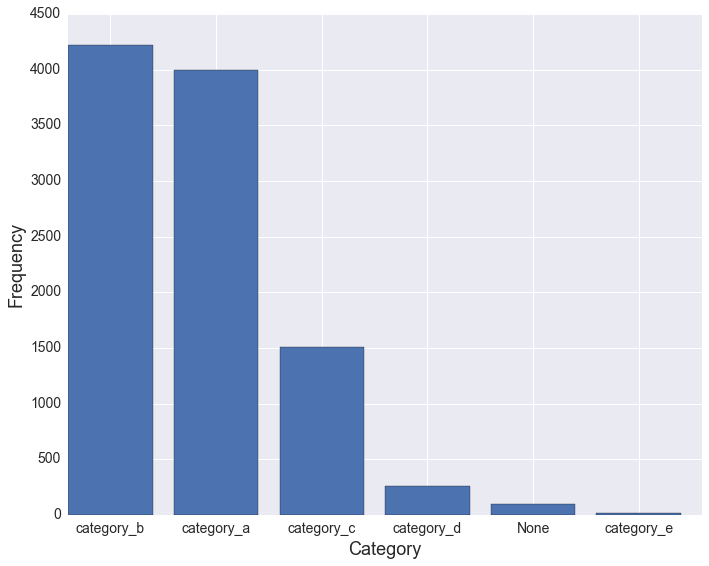

In [10]:
plt.bar(np.arange(category_hist_df.shape[0]), category_hist_df.freq)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(np.arange(category_hist_df.shape[0]) + 0.4, category_hist_df.category)
plt.tight_layout()

## Numeric Values

In [11]:
numeric_hist_df = get_histogram_values('test_data', 'x_col', nbins=25)

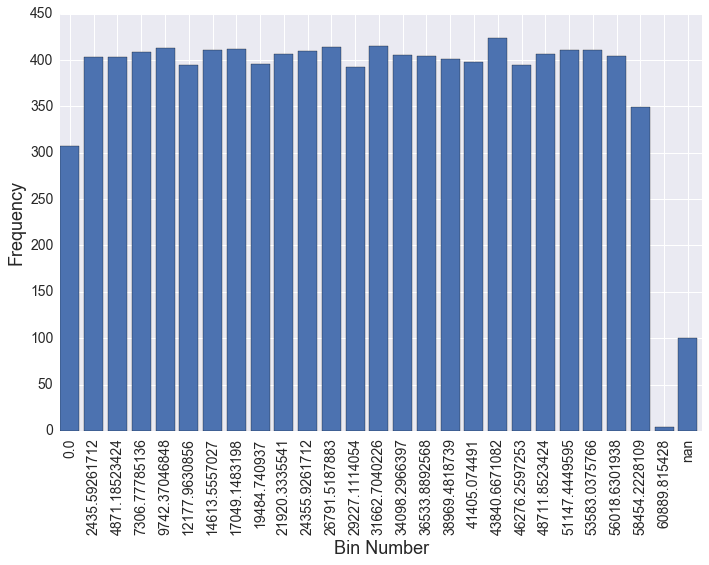

In [12]:
plt.bar(np.arange(numeric_hist_df.shape[0]), numeric_hist_df.freq)
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.xticks(np.arange(numeric_hist_df.shape[0]) + 0.4, numeric_hist_df.bin_nbr, rotation=90)
plt.xlim(0, numeric_hist_df.shape[0])
plt.tight_layout()

## Recasting values
If a numeric field is misrepresented as text.

In [13]:
recasted_hist_df = get_histogram_values('test_data', 'uncasted_col', nbins=25, cast_as='float')

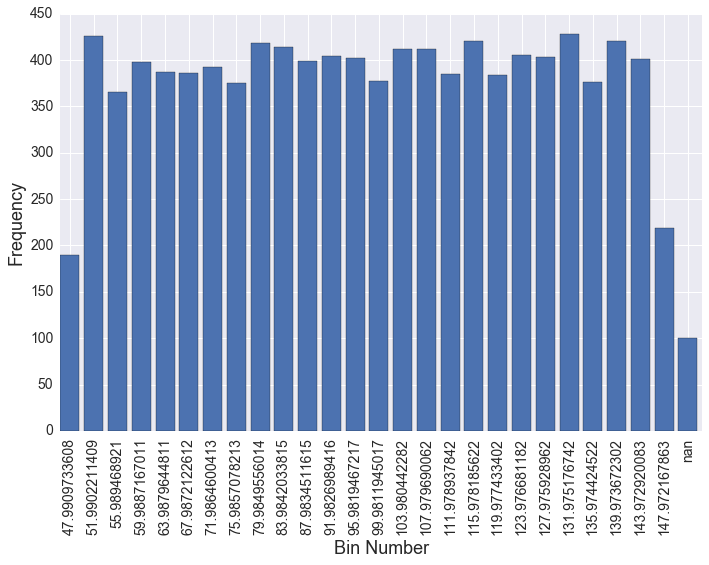

In [14]:
plt.bar(np.arange(recasted_hist_df.shape[0]), recasted_hist_df.freq)
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.xticks(np.arange(recasted_hist_df.shape[0]) + 0.4, recasted_hist_df.bin_nbr, rotation=90)
plt.xlim(0, recasted_hist_df.shape[0])
plt.tight_layout()

# Plot the Summarized Data as a Scatter Plot
## Make Sizes Relative to Amount of Data

In [15]:
scatter_df = get_scatterplot_values('test_data', 'x_col', 'y_col', nbins=(50, 50))

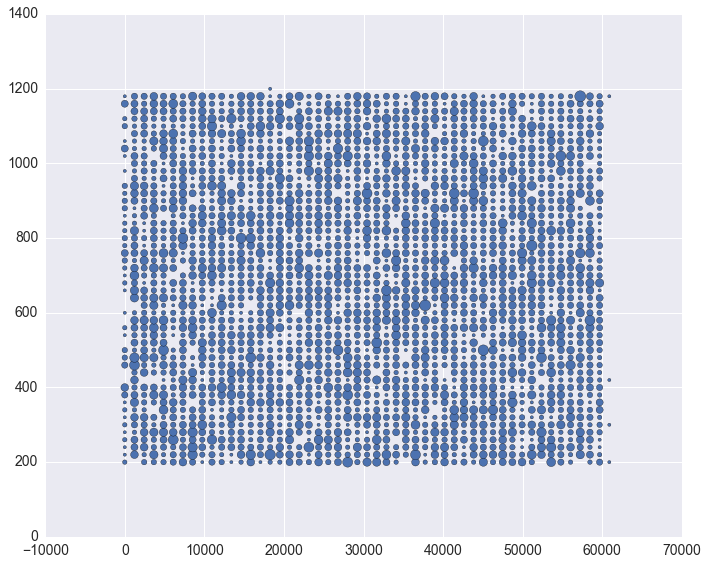

In [16]:
plt.scatter(scatter_df.bin_nbr_x, scatter_df.bin_nbr_y, c=blue, s=10*scatter_df.freq)
plt.tight_layout()

## Add Opacity

In [17]:
colour_matrix = np.zeros((scatter_df.dropna().shape[0], 4))
colour_matrix[:, :3] = blue
colour_matrix[:, 3] = scatter_df.dropna().freq/np.max(scatter_df.dropna().freq)

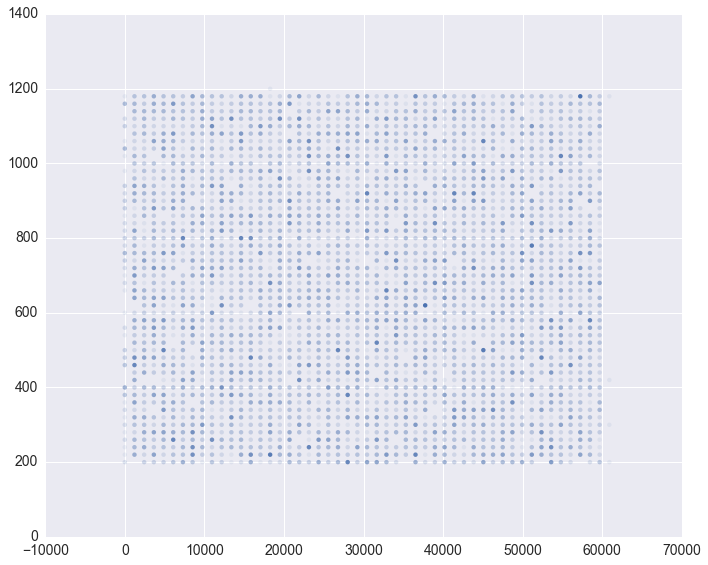

In [18]:
plt.scatter(scatter_df.bin_nbr_x, scatter_df.bin_nbr_y, c=colour_matrix, lw=0)
plt.tight_layout()

In [19]:
## TODO: Make hexbin, casting for scatterplot